# Simulator Developer

### [list of logs available]

A. Stop

A.1  streaming

- log_bus_ref: reference of every vehicle that passed by/stopped at the stop
- log_arr_t: inferred arrival time of every vehicle that passed by/stopped at the stop
- log_dep_t: inferred departure time of every vehicle that passed by/stopped at the stop
- log_headway: calculated headway, chronological
- log_dwell_t: inferred dwell time, chronological
- log_q: calculated q parameter, chronological

A.2 simulation

- sim_arr_t: arrival time of every SimBus vehicle
- sim_dep_t: departure time of every SimBus vehicle
- sim_headway: headway between every SimBus vehicle

B. Link

- log_speed: every inferred speed from streaming, chronological

C. SimBus

- log_pos: vehicle location (distance along route) by second
- log_time: timestamp by second
- log_status: vehicle action by second
- log_speed: vehicle speed by second
- log_dwell: vehicle dwelling time, recorded once upon reaching a stop
- log_hold: vehicle holding time, recorded once upon reaching a stop
- log_stop: stop index, recorded once upon reaching a stop

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import buskit as bk
from buskit import busdata as bdata
from buskit import dashboard as bdash
from buskit import simulator as bsim

from IPython.display import display, clear_output

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [32]:
# specify path to the archive AVL file
# archive_path = 'MTA_data/B46%2B-180716-171100-44650-Mon.csv'
# archive_path = 'MTA_data/B15-180705-145946-44650-Thu.csv'
archive_path = 'MTA_data/B15-180625-235941-44650-Mon.csv'
# archive_path = 'MTA_data/M1-180705-150014-44650-Thu.csv'

# specify direction and time
direction = 1
time = 120 # minutes

# Original trajectory

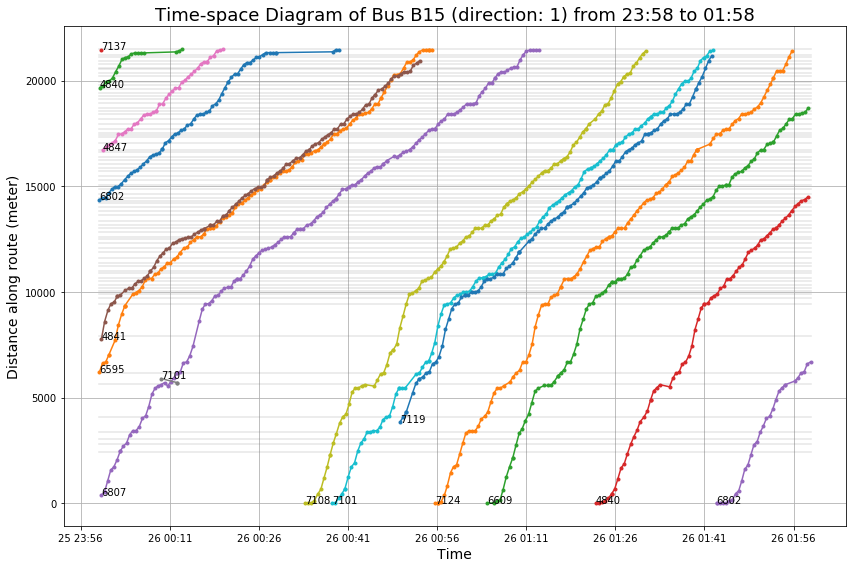

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x127284eb8>)

In [33]:
# plot TSD for cross-validation
df = pd.read_csv(archive_path)
df = bdata.split_trips(df)
bdata.plot_tsd(df, direction, 0, time)

# Simulation without control

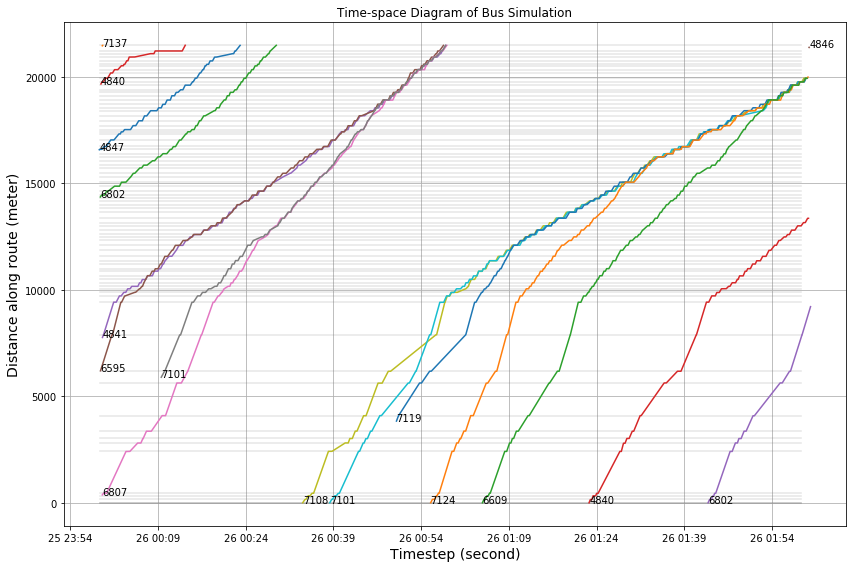

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x129383c88>)

In [34]:
# reset stops, links, and buses
stops_0, links_0, stop_pos = bsim.set_route(archive_path, direction)
infer_bus = {} # Bus objs for infer buffering only
live_bus = {} # Bus objs for streaming live
active_bus_0 = {} # SimBus objs for simulation

# infer half an hour for initial data
bsim.infer(archive_path, direction, infer_bus, stops_0, links_0, stop_pos, 30)

# run simulation without control
report_0 = bsim.simulate(archive_path, direction, live_bus, active_bus_0, stops_0, links_0, stop_pos, sim_time=time)

# plot result tsd
bsim.sim_tsd(active_bus_0, stops_0, archive_path, direction, 0, time)

# Simulation with control 1: fixed holding
### Hold bus within 10-minute headway for 1 minute at each stop until relieved

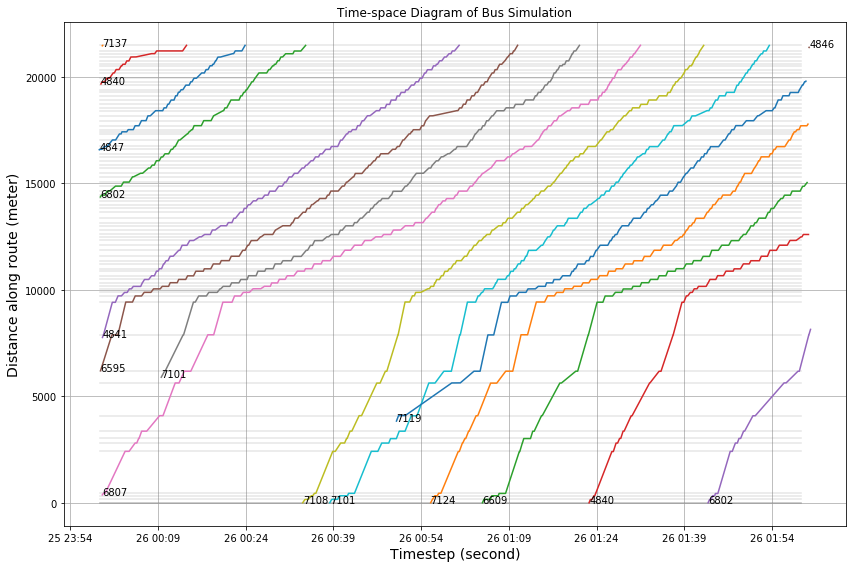

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x120761c88>)

In [35]:
# reset stops, links, and buses
stops_1, links_1, stop_pos = bsim.set_route(archive_path, direction)
infer_bus = {} # Bus objs for infer buffering only
live_bus = {} # Bus objs for streaming live
active_bus_1 = {} # SimBus objs for simulation

# infer half an hour for initial data
bsim.infer(archive_path, direction, infer_bus, stops_1, links_1, stop_pos, 30)

# run simulation with control
report_1 = bsim.simulate(archive_path, direction, live_bus, active_bus_1, stops_1, links_1, stop_pos, control=1, sim_time=time)

# plot result tsd
bsim.sim_tsd(active_bus_1, stops_1, archive_path, direction, 0, time)

# Simulation with control 2: naive headway
### Hold bus within 10-minute headway until fulfilled

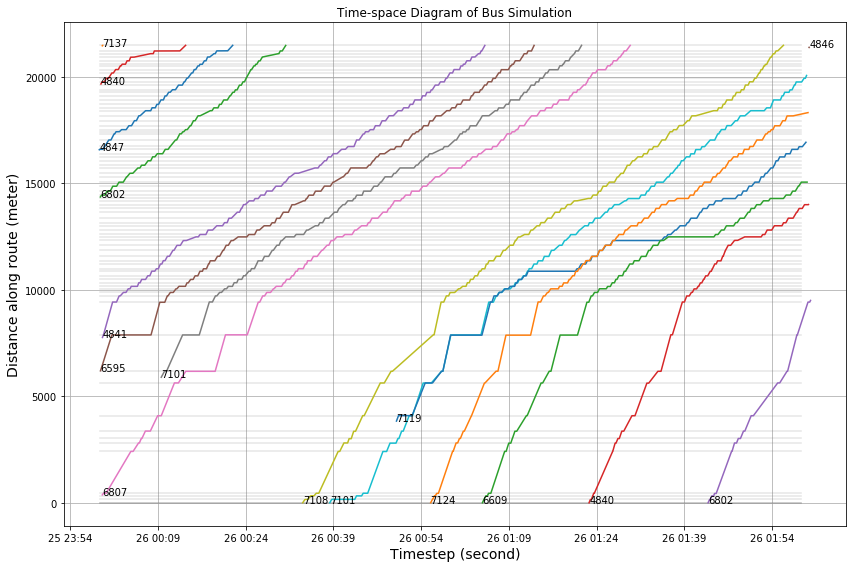

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12073ffd0>)

In [36]:
# reset stops, links, and buses
stops_2, links_2, stop_pos = bsim.set_route(archive_path, direction)
infer_bus = {} # Bus objs for infer buffering only
live_bus = {} # Bus objs for streaming live
active_bus_2 = {} # SimBus objs for simulation

# infer half an hour for initial data
bsim.infer(archive_path, direction, infer_bus, stops_2, links_2, stop_pos, 30)

# run simulation with control
report_2 = bsim.simulate(archive_path, direction, live_bus, active_bus_2, stops_2, links_2, stop_pos, control=2, sim_time=time)

# plot result tsd
bsim.sim_tsd(active_bus_2, stops_2, archive_path, direction, 0, time)

# Reports

In [37]:
# simulation performance
# not a very good measure, but still, the lower the better
# a temporary indicator for simulator calibration
bsim.eval_sim(archive_path, active_bus_0, direction)

MSE of simulated vehicle distance (meter) per ping pair: 2122589.19


2122589.1924660336

In [38]:
# route performance metrics across different control strategies
bsim.sim_report([report_0, report_1, report_2])

,bunch,hold,avghw,stdhw
0,15153,0.0,15.608463,16.481596
1,111,11280.0,12.015003,5.857195
2,1765,9511.0,12.779904,8.946602


In [ ]:
- Holding Strategies； in dense run setting
- eliminate convergence; different dwelling time settings
- proceedings after controls take place appear too ideal (equal-spacing)
- Remove/solve incomplete vehicle pings?
- poisson

experiment setting: scope, time
def of BB: time (determine hold), space (evaluating)

separate comparison:
    live <> sim
    sim <> control

by OD (as a function?):
    wait_time = 0.5 * hw?
    in-vehicle traveling time
    delay time：by vehicle, by stop, by pax, distribution of hold times across the route

In [ ]:
# # parse stops and set links
# stops, links, stop_pos = bsim.set_route(archive_path, 1)

# # create empty dictionary storage for bus objects
# live_bus = {} # for buses from archive streaming
# active_bus = {} # for buses in the simulator

###

# bsim.infer(archive_path, 1, live_bus, stops, links, stop_pos, 360)

# speeds = [np.mean(l.log_speed) for l in links.values() if np.mean(l.log_speed) != nan]
# speeds = np.array(speeds)[~np.isnan(speeds)]

# mean([mean(l.log_speed) for l in links.values() if len(l.log_speed) > 0])

# speeds = [l.log_speed for l in links.values() if np.mean(l.log_speed) != nan]
# flat_list = [item for sublist in speeds for item in sublist if item < 25]

# plt.hist(flat_list, bins=100)

###

# d = [s.log_dwell_t for s in stops.values()]
# w = [s.log_wait_t for s in stops.values()]

# d_flat = [item for sublist in d for item in sublist]
# w_flat = [item for sublist in w for item in sublist]

# qs = [s.log_q for s in stops.values()]
# qs = [item for sublist in qs for item in sublist if item < 1]
# plt.hist(qs)

###

# not working, dictionary is not subscriptable
# def extract(dictionary, log):
#     """
#     extract all non-None elements of a log from all objects of a dictionary
#     log: name of the log in string
#     """
#     all_log = [obj[log] for obj in dictionary.values()]
#     all_item = [item for log in all_log for item in log if item != None]
#     return all_item

# def eval_strategy(names, simbus_dicts, stop_dicts):
#     """
#     evaluates multiple simulation results
#     names: a list of names representing each simulation
#     simbus_dicts: a list of SimBus dictionaries after each corresponding simulation
#     stop_dicts: a list of Stop dictionaries after each corresponding simulation
#     """
#     for d in simbus_dicts:

In [ ]:
# ### SHOULD REWRITE INTO STREAMING-BASED READER ###
# # read archive data
# # A: use reader (currently problematic)
# def archive_reader(data, dir_ref, start_min=None, end_min=None):
#     df = pd.read_csv(data)

#     # subset direction
#     df = df[df['DirectionRef'] == dir_ref]

#     # parse time format
#     ##### UNABLE TO GET DATETIME.DATETIME TYPE, ALWAYS TIMESTAMP, WHY? #####
# #     df.loc[:,'RecordedAtTime'] = list(map(dateutil.parser.parse, df['RecordedAtTime']))
#     df.loc[:,'RecordedAtTime'] = pd.to_datetime(df['RecordedAtTime']) \
#                                    .dt.tz_localize('UTC') \
#                                    .dt.tz_convert('America/New_York')

#     # subset time
#     start = df["RecordedAtTime"].min()
#     end = df["RecordedAtTime"].max()

#     s = start if start_min == None else start + timedelta(minutes=start_min)
#     e = end if end_min == None else start + timedelta(minutes=end_min)

#     bool1 = np.array(df['RecordedAtTime'] > s)
#     bool2 = np.array(df['RecordedAtTime'] < e)
#     df = df[bool1 & bool2]
    
#     return df

# df = archive_reader(archive_path, 1, 0, 180)

# # B: read directly
# df = pd.read_csv(archive_path)
# df = bdata.split_trips(df)

# # match time
# # attempt 1: match two set of time
# time1 = set(map(dateutil.parser.parse, df[df['NewVehicleRef'] == 'MTA NYCT_6802_1']['RecordedAtTime']))
# time2 = set(active_bus_1['MTA NYCT_6802'].log_time)
# mut = time1.intersection(time2)
# [active_bus_1['MTA NYCT_6802'].log_pos[i] for i, t in enumerate(active_bus_1['MTA NYCT_6802'].log_time) if t in mut] 

# # attempt 2: just take archive time list directly
# time1 = list(map(dateutil.parser.parse, df[df['NewVehicleRef'] == 'MTA NYCT_6802_1']['RecordedAtTime']))
# sort(time1)
# [active_bus_1['MTA NYCT_6802'].log_pos[i] for i, t in enumerate(active_bus_1['MTA NYCT_6802'].log_time) if t in time1] # check if length match time1 or not

# ### remember to exclude duplicated first initiating record

# def eval_sim(data, bus_dict, dir_ref, start_min=None, end_min=None):
#     """
#     evaluates how well the simulation is compared to the original archive
#     data: 
#     bus_dict: active_bus information from simulation
#     """
#     # read data
#     # df = archive_reader(data, dir_ref, start_min, end_min) # incomplete
#     df = pd.read_csv(data)
#     df = bdata.split_trips(df)
    
#     buses1 = set(df['NewVehicleRef'])
#     buses2 = set(bus_dict.keys())
#     mutual_ref = buses1.intersection(buses2)
    
#     sim_mse = [] # mse from all runs
#     for ref in mutual_ref:
#         time1 = set(map(dateutil.parser.parse, df[df['NewVehicleRef'] == 'MTA NYCT_4840_2']['RecordedAtTime']))
#         time2 = set(active_bus_2['MTA NYCT_4840_2'].log_time)
#         mutual_time = time1.intersection(time2)
        
#         for time in mutual_time:

#         bus_dict1[ref].pos
#         bus_dict2[ref].pos
        
#         err = [array of difference btwn pos lists]
#         mse = np.mean(err^2)
#         sim_mse.append(mse)
#     result = np.mean(sim_mse) / duration
#     return result # mse per run per time unit

# len(pos1.keys()), len(pos2.keys()), len(set(pos1.keys()).intersection(set(pos2.keys())))